<a href="https://colab.research.google.com/github/fran-scala/ML_exam_PhD/blob/main/ML_exam_PhD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# installing useful libraries
! pip install pennylane --quiet
! pip install seaborn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 41.2 MB/s eta 0:00:00


# Machine Learing exam

In this notebook we want to apply Machine Learning techniques to classify quantum states possibly coming from an experiment. The main goal is to distinguish *random* quantum states (which can be seen as background noise) from states having a particular distribution (the ones coming from the experiment). Quantum states will be complex matrices produced by *quantum circuits* through `pennylane` Python library.



In [2]:
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import jax # require for Just In Time (JIT) compilation

jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import optax  # optimization using jax

import pennylane as qml
import pennylane.numpy as pnp

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
sns.set()

# 1. Binary Classification

In this section, we construct a Multi Layers Perceptron (MLP) to detect which quantum states are coming from the desired experiment.

The first phenomenon we study the effect of the dataset size.
In fact, since quantum states of $n$ qubits live in a Hilbert space of dimension $d=2^n$ which is exponential in the number of qubits itself, one can see that a fixed dataset size leads to overfitting and poor performance of the model as the number of qubits increases.
For this reason, we will repeat the training procedure with different datasets corresponding to different numbers of qubits ($n\in\{2,3,4,5\}$) for both the case with fixed (Sec 1.0) and exponential (Sec 1.1) dataset sizes.



(We gathered the results of the different trainings in a single file and then we compare the results through their loss histories and ROC curves. One can skip directly to the *Multi-qubit data analysis* sections (1.1.3 and 1.2.3) load the data and see the results.)

### 1.0.1 Make binary dataset function

In [ ]:
def make_binary_dataset(n_qubits, size=4000):

    seed = 12345
    np.random.seed(seed=seed)

    # device producing quantum states
    device = qml.device("default.qubit.jax", wires=n_qubits,)

    @qml.qnode(device,interface='jax')
    def random_circuit(thetas, wires):
        ''' Function implementing a quantum circuit
          if the number of layers is high (>10)
          then the circuit produces random states'''
        assert len(thetas)%layers == 0

        wires = range(n_qubits)

        k = 0
        # LAYERS OF QUANTUM OPERATIONS
        for lay in range(20):
          for i in wires:
              qml.RY(np.pi/2, wires=i)
          for i in wires:
              qml.RZ(thetas[k], wires=i)
              k += 1
          for qb in wires[:-1]:
              qml.CNOT(wires=[wires[qb], wires[qb+1]])
          for i in wires:
              qml.RX(thetas[k], wires=i)
              k += 1
        return qml.density_matrix(wires=wires)

    @qml.qnode(device,interface='jax')
    def specific_circuit(thetas, wires):
        ''' Function implementing a quantum circuit
          if the number of layers is high (>10)
          then the circuit produces random states'''
        assert len(thetas)%layers == 0

        wires = range(n_qubits)

        k = 0
        # LAYERS OF QUANTUM OPERATIONS
        for lay in range(2):
          for i in wires:
              qml.RY(np.pi/2, wires=i)
          for i in wires:
              qml.RZ(thetas[k], wires=i)
              k += 1
          for qb in wires[:-1]:
              qml.CNOT(wires=[wires[qb], wires[qb+1]])
          for i in wires:
              qml.RX(thetas[k], wires=i)
              k += 1
        return qml.density_matrix(wires=wires)

    # producing random states
    random_states = int(size/2) #2000 random states
    layers = 20
    n_params = n_qubits*layers*2

    key = jax.random.PRNGKey(12345)
    thetas = 2*jnp.pi*jax.random.uniform(key, shape=(random_states,n_params))
    r_circ = jax.jit(random_circuit)
    rand_states_dataset = []

    for t in thetas:
      rand_states_dataset.append(r_circ(thetas=t, wires=[i for i in range(n_qubits)]))

    #producing non-random states

    non_random_states = int(size/2) #2000 random states
    layers = 2
    n_params = n_qubits*layers*2

    key = jax.random.PRNGKey(54321)
    thetas = 2*jnp.pi*jax.random.uniform(key, shape=(non_random_states,n_params))
    circ = jax.jit(specific_circuit)
    non_rand_states_dataset = []

    for t in thetas:
      non_rand_states_dataset.append(circ(thetas=t, wires=[i for i in range(n_qubits)]))

    rand_states_dataset = np.array(rand_states_dataset)
    non_rand_states_dataset = np.array(non_rand_states_dataset)

    X = np.concatenate([rand_states_dataset, non_rand_states_dataset], axis=0)
    y = np.concatenate([np.zeros(random_states, dtype=int), np.ones(non_random_states, dtype=int)])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40, shuffle=True)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=50, shuffle=True)

    return X_train, X_val, X_test, y_train, y_val, y_test


### 1.0.2 Create binary dataset

In [ ]:
# dictionary in which we will store the data
data_dict={}

## 1.1 Fixed dimension dataset

In [ ]:
n_qubits = 2 # quantum unit of computation
            # determining the dimension of the state matrix
            # matrix.shape = (2**(n_qubits),2**(n_qubits))
size = 4000
(X_train, X_val, X_test,
 y_train, y_val, y_test) = make_binary_dataset(n_qubits, size)

In [ ]:
print('train\t\t',X_train.shape)
print('validation\t',X_val.shape)
print('test\t\t',X_test.shape)

train		 (2800, 32)
validation	 (600, 32)
test		 (600, 32)


In [ ]:
# flatten the matrices and splitting real and imaginary part
X_train = np.array(list(map(lambda x: np.concatenate([x.real.flatten(),x.imag.flatten()]), X_train)))
print(X_train.shape)
X_val = np.array(list(map(lambda x: np.concatenate([x.real.flatten(),x.imag.flatten()]), X_val)))
X_test = np.array(list(map(lambda x: np.concatenate([x.real.flatten(),x.imag.flatten()]), X_test)))

(2800, 32)


### 1.1.1 Build and train model

To address this classification task one can employ a Multi-Layer Perceptron. Since we are performing binary classification it is important that the output layer has only one neuron with `sigmoid` activation function.

In [ ]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [ ]:
input_shape = ((2**n_qubits)**2)*2
dropoutRate = 0.25 # without dropout overfitting can be seen already at 4 qubits

####
inputArray = Input(shape=(input_shape,))
#
x = Dense(256, activation='relu')(inputArray)
x = Dropout(dropoutRate)(x)
#
x = Dense(40, activation='relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(20)(x)
x = Activation('relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(10, activation='relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(5, activation='relu')(x)
#
output = Dense(1, activation='sigmoid')(x)#'softmax'
####
model = Model(inputs=inputArray, outputs=output)

For the same reason we employ the `binary_crossentropy` as the the cost function for our training.

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()

In [ ]:
batch_size = 28
n_epochs = 100

# train
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])


### 1.1.2 Data analysis

In this section, we evaluate the performance of the trained model. As a first step one can give a look to the (train and validation) loss history during training. From this one can check if the training procedure was succesful and detect the possible presence of overfitting.

(Here the cell is commented because we will get back on this below when we compare all the trainings.)

In [ ]:
## PLOTTING HISTORY

# # plot training history
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# # plt.yscale('log')
# plt.title('Training History')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['training', 'validation'], loc='upper right')
# plt.show()



In [ ]:
data_dict[n_qubits] = {}
data_dict[n_qubits]['loss'] = list(history.history['loss'])
data_dict[n_qubits]['val_loss'] = list(history.history['val_loss'])

In [ ]:
from sklearn.metrics import roc_curve, auc
predict_test = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, predict_test)

# plt.plot(fpr,tpr,)
# plt.ylabel('TPR')
# plt.xlabel('FPR')


19/19 [==============================] - 0s 2ms/step


In [ ]:
data_dict[n_qubits]['tpr'] = list(tpr)
data_dict[n_qubits]['fpr'] = list(fpr)

In [ ]:
for k,v in data_dict.items():
  print('n_qubits',k)

n_qubits 2
n_qubits 3
n_qubits 4
n_qubits 5


In [ ]:
# mounting drive for saving and loading results
# if you're using colab
try:
  from google.colab import drive
  drive.mount('/content/drive')
  home_dir = '/content/drive/My Drive'

# if you're not using colab the drive folder doesn't exist
# so load the data from the github repo you cloned
except:
  home_dir = '/data_dir'

In [ ]:
import pandas as pd

def load_fix_dim_data():
  ''' load the dictionary and format all entries
  so they are again arrays and not str'''

  data_dict = {}
  try:
    data_pd = pd.read_csv(home_dir+'/MLP_multiqubit_train_val_tpr_fpr.csv', index_col=0)
  except:
    print('Error!! Returning empty dict')
    return {}
  for n_qubits in data_pd.columns:
    data_dict[int(n_qubits)] = {}
    for prop in data_pd.index:

      tmp = data_pd[[n_qubits]].loc[prop].values[0]
      tmp = tmp[1:-1].split(', ')
      data_dict[int(n_qubits)][prop] = list(np.array(tmp, dtype=float))

  return data_dict



In [ ]:
old_data = load_fix_dim_data()

for k,v in data_dict.items():
  if k not in old_data.keys():
    old_data[k] = v

In [ ]:
old_data.keys()

dict_keys([2, 3, 4, 5])

In [ ]:
# saving data
pd.DataFrame(old_data).to_csv(home_dir+'/MLP_multiqubit_train_val_tpr_fpr.csv')


### 1.1.3 Multi-qubit data analysis

#### 1.1.3.0 Load data

In [182]:
# mounting drive for saving and loading results
# if you're using colab
try:
  from google.colab import drive
  drive.mount('/content/drive')
  home_dir = '/content/drive/My Drive'

# if you're not using colab the drive folder doesn't exist
# so load the data from the github repo you cloned
except:
  home_dir = '/data_dir'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [183]:
import pandas as pd

def load_fix_dim_data():
  ''' load the dictionary and format all entries
  so they are again arrays and not str'''

  data_dict = {}
  try:
    data_pd = pd.read_csv(home_dir+'/MLP_multiqubit_train_val_tpr_fpr.csv', index_col=0)
  except:
    print('Error!! Returning empty dict')
    return {}
  for n_qubits in data_pd.columns:
    data_dict[int(n_qubits)] = {}
    for prop in data_pd.index:

      tmp = data_pd[[n_qubits]].loc[prop].values[0]
      tmp = tmp[1:-1].split(', ')
      data_dict[int(n_qubits)][prop] = list(np.array(tmp, dtype=float))

  return data_dict



#### 1.1.3.1 Analysis

As expected, employing a fixed dataset size of 4000 elements works fine for small number of qubits, but as soon as we increase the number of qubits this is not working anymore. This is witnessed by a drop in the AUC and highlighted by the ROC curve

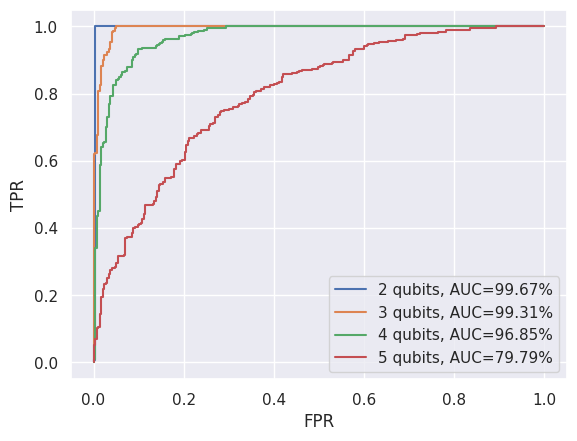

In [184]:
loaded_data = load_fix_dim_data()

for k, v in loaded_data.items():
  tpr = v['tpr']
  fpr = v['fpr']
  auc_ =  auc(fpr, tpr)
  plt.plot(fpr,tpr,label=f'{k} qubits, AUC={auc_*100:.2f}%')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend()

By plotting the training history for different number of qubits we can see that as the number of qubits increases the overfitting phenomenon starts to arise. This is strictly linked to the fact that the dataset is not fully representative of the space and the model learns specifics patterns instead of general features.

In the next section we will show that employing an exponential number of data one does not incurr in overfitting.

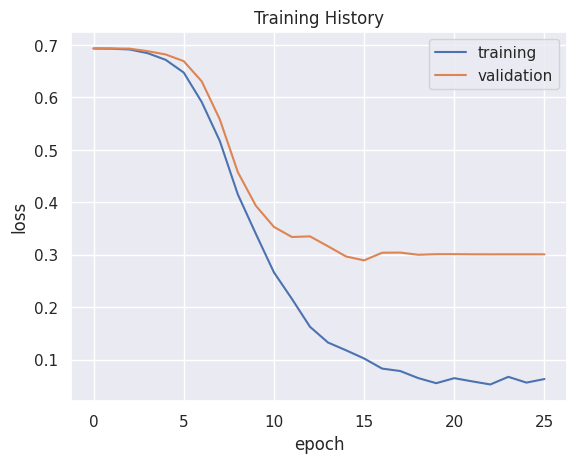

In [187]:
n = 4 # number of qubits (4 and 5 are interesting)
loss = loaded_data[n]['loss']
val_loss = loaded_data[n]['val_loss']

# plot training history
plt.plot(loss)
plt.plot(val_loss)
# plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## 1.2 Exponentially big dataset

In [173]:
# dictionary in which we will store the data
data_dict={}

In [ ]:
n_qubits = 2 # quantum unit of computation
            # determining the dimension of the state matrix
            # matrix.shape = (2**(n_qubits),2**(n_qubits))
size = 2**n_qubits*1000
(X_train, X_val, X_test,
 y_train, y_val, y_test) = make_binary_dataset(n_qubits, size)

In [ ]:
print('train\t\t',X_train.shape)
print('validation\t',X_val.shape)
print('test\t\t',X_test.shape)

train		 (2800, 4, 4)
validation	 (600, 4, 4)
test		 (600, 4, 4)


In [ ]:
# flatten the matrices and splitting real and imaginary part
X_train = np.array(list(map(lambda x: np.concatenate([x.real.flatten(),x.imag.flatten()]), X_train)))
print(X_train.shape)
X_val = np.array(list(map(lambda x: np.concatenate([x.real.flatten(),x.imag.flatten()]), X_val)))
X_test = np.array(list(map(lambda x: np.concatenate([x.real.flatten(),x.imag.flatten()]), X_test)))

(2800, 32)


### 1.2.1 Build and train model

To address this classification task one can employ a Multi-Layer Perceptron. Since we are performing binary classification it is important that the output layer has only one neuron with `sigmoid` activation function.

In [ ]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [ ]:
input_shape = ((2**n_qubits)**2)*2
dropoutRate = 0.25

####
inputArray = Input(shape=(input_shape,))
#
x = Dense(40, activation='relu')(inputArray)
x = Dropout(dropoutRate)(x)
#
x = Dense(20)(x)
x = Activation('relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(10, activation='relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(5, activation='relu')(x)
#
output = Dense(1, activation='sigmoid')(x)#'softmax'
####
model = Model(inputs=inputArray, outputs=output)

For the same reason we employ the `binary_crossentropy` as the the cost function for our training.

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()

In [ ]:
batch_size = 28
n_epochs = 100

# train
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])


### 1.2.2 Data analysis

In this section, we evaluate the performance of the trained model. As a first step one can give a look to the (train and validation) loss history during training. From this one can check if the training procedure was succesful and detect the possible presence of overfitting.

(Here the cell is commented because we will get back on this below when we compare all the trainings.)

In [168]:
## PLOTTING HISTORY

# # plot training history
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# # plt.yscale('log')
# plt.title('Training History')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['training', 'validation'], loc='upper right')
# plt.show()



In [ ]:
data_dict[n_qubits] = {}
data_dict[n_qubits]['loss'] = list(history.history['loss'])
data_dict[n_qubits]['val_loss'] = list(history.history['val_loss'])

In [ ]:
from sklearn.metrics import roc_curve, auc
predict_test = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, predict_test)

# plt.plot(fpr,tpr,)
# plt.ylabel('TPR')
# plt.xlabel('FPR')


In [ ]:
data_dict[n_qubits]['tpr'] = list(tpr)
data_dict[n_qubits]['fpr'] = list(fpr)

In [ ]:
for k,v in data_dict.items():
  print('n_qubits',k)

In [181]:
# mounting drive for saving and loading results
# if you're using colab
try:
  from google.colab import drive
  drive.mount('/content/drive')
  home_dir = '/content/drive/My Drive'

# if you're not using colab the drive folder doesn't exist
# so load the data from the github repo you cloned
except:
  home_dir = '/data_dir'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
True


In [174]:
import pandas as pd

def load_exp_data():
  ''' load the dictionary and format all entries
  so they are again arrays and not str'''

  data_dict = {}
  try:
    data_pd = pd.read_csv(home_dir+'/MLP_exponential_multiqubit_train_val_tpr_fpr.csv', index_col=0)
  except:
    print('Error!! Returning empty dict')
    return {}
  for n_qubits in data_pd.columns:
    data_dict[int(n_qubits)] = {}
    for prop in data_pd.index:

      tmp = data_pd[[n_qubits]].loc[prop].values[0]
      tmp = tmp[1:-1].split(', ')
      data_dict[int(n_qubits)][prop] = list(np.array(tmp, dtype=float))

  return data_dict


In [ ]:
old_data = load_exp_data()

for k,v in data_dict.items():
  if k not in old_data.keys():
    old_data[k] = v

In [ ]:
old_data.keys()

In [ ]:
# saving data
pd.DataFrame(old_data).to_csv(home_dir+'/MLP_exponential_multiqubit_train_val_tpr_fpr.csv')


### 1.2.3 Multi qubit data analysis

#### 1.1.3.0 Load data

In [188]:
# mounting drive for saving and loading results
# if you're using colab
try:
  from google.colab import drive
  drive.mount('/content/drive')
  home_dir = '/content/drive/My Drive'

# if you're not using colab the drive folder doesn't exist
# so load the data from the github repo you cloned
except:
  home_dir = '/data_dir'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [189]:
import pandas as pd

def load_exp_data():
  ''' load the dictionary and format all entries
  so they are again arrays and not str'''

  data_dict = {}
  try:
    data_pd = pd.read_csv(home_dir+'/MLP_exponential_multiqubit_train_val_tpr_fpr.csv', index_col=0)
  except:
    print('Error!! Returning empty dict')
    return {}
  for n_qubits in data_pd.columns:
    data_dict[int(n_qubits)] = {}
    for prop in data_pd.index:

      tmp = data_pd[[n_qubits]].loc[prop].values[0]
      tmp = tmp[1:-1].split(', ')
      data_dict[int(n_qubits)][prop] = list(np.array(tmp, dtype=float))

  return data_dict

#### 1.1.3.1 Analysis

With the increased dataset dimension we were able to obtain almost perfect results $\left(AUC\approx1\right)$ for all the studied cases.

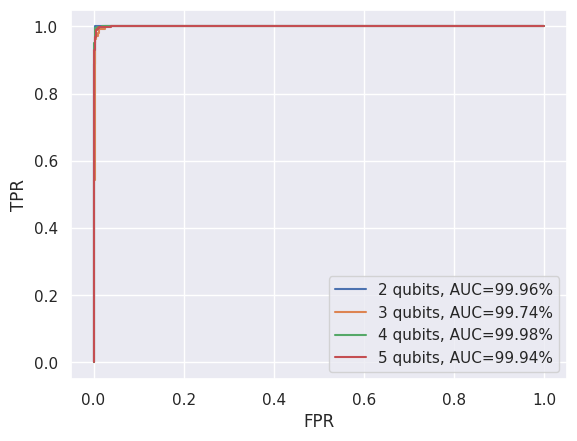

In [190]:
loaded_data = load_exp_data()

for k, v in sorted(loaded_data.items()):
  tpr = v['tpr']
  fpr = v['fpr']
  auc_ =  auc(fpr, tpr)
  plt.plot(fpr,tpr,label=f'{k} qubits, AUC={auc_*100:.2f}%')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend()

One can also check that overfitting completely disappeared for the cases with 4 and 5 qubits.

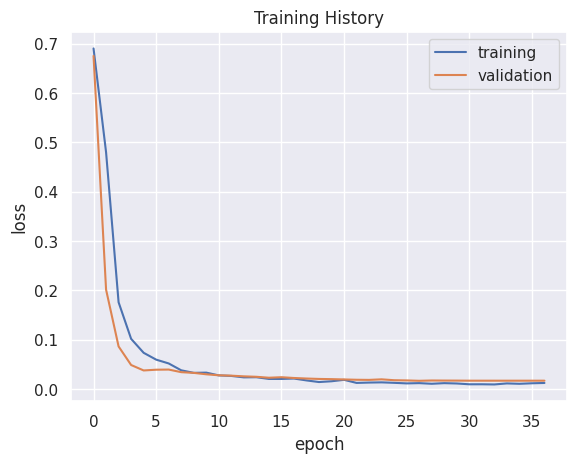

In [193]:
n = 4 # number of qubits (4 and 5 are interesting)
loss = loaded_data[n]['loss']
val_loss = loaded_data[n]['val_loss']

# plot training history
plt.plot(loss)
plt.plot(val_loss)
# plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# 2. Multiclass classification

In this section, we complicate the classification task by adding data coming from different experiments (extra classes) to be distinguished one from the other and from noise. This is done for 5 qubits with exponentially big dataset (equally divided in 3 classes). We will see that the MLP employed in the previous section is able to perform well also in this case, but employing a CNN will improve the performance while reducing the number of parameters (from 80k to 30k).

### 2.0.1 Build multiclass dataset function

In [3]:
from sklearn.preprocessing import OneHotEncoder

def make_multiclass_dataset(n_qubits, size=4000):

    seed = 12345
    np.random.seed(seed=seed)

    # device producing quantum states
    device = qml.device("default.qubit.jax", wires=n_qubits,)

    @qml.qnode(device,interface='jax')
    def random_circuit(thetas, wires):
        ''' Function implementing a quantum circuit
          if the number of layers is high (>10)
          then the circuit produces random states'''
        assert len(thetas)%layers == 0
        wires = range(n_qubits)

        k = 0
        # LAYERS OF QUANTUM OPERATIONS
        for lay in range(20):
          for i in wires:
              qml.RY(np.pi/2, wires=i)
          for i in wires:
              qml.RZ(thetas[k], wires=i)
              k += 1
          for qb in wires[:-1]:
              qml.CNOT(wires=[wires[qb], wires[qb+1]])
          for i in wires:
              qml.RX(thetas[k], wires=i)
              k += 1
        return qml.density_matrix(wires=wires)

    @qml.qnode(device,interface='jax')
    def specific_circuit_1(thetas, wires):
        ''' employs parametrized RZ and RX rotations'''
        assert len(thetas)%layers == 0
        wires = range(n_qubits)

        k = 0
        # LAYERS OF QUANTUM OPERATIONS
        for lay in range(layers):
          for i in wires:
              qml.RY(np.pi/2, wires=i)
          for i in wires:
              qml.RZ(thetas[k], wires=i)
              k += 1
          for qb in wires[:-1]:
              qml.CNOT(wires=[wires[qb], wires[qb+1]])
          for i in wires:
              qml.RX(thetas[k], wires=i)
              k += 1
        return qml.density_matrix(wires=wires)
    @qml.qnode(device,interface='jax')
    def specific_circuit_2(thetas, wires):
        ''' employs parametrized RY and RZ rotations'''
        assert len(thetas)%layers == 0
        wires = range(n_qubits)

        k = 0
        # LAYERS OF QUANTUM OPERATIONS
        for lay in range(layers):
          for i in wires:
              qml.RY(np.pi/2, wires=i)
          for i in wires:
              qml.RX(thetas[k], wires=i)
              k += 1
          # for qb in wires[:-1]:
          #     qml.CNOT(wires=[wires[qb], wires[qb+1]])
          for i in wires:
              qml.RZ(thetas[k], wires=i)
              k += 1
        return qml.density_matrix(wires=wires)
    # producing random states
    random_states = int(size/3)
    layers = 20
    n_params = n_qubits*layers*2

    key = jax.random.PRNGKey(12345)
    thetas = 2*jnp.pi*jax.random.uniform(key, shape=(random_states,n_params))
    r_circ = jax.jit(random_circuit)
    rand_states_dataset = []

    for t in thetas:
      rand_states_dataset.append(r_circ(thetas=t, wires=[i for i in range(n_qubits)]))

    #producing non-random states
    #process 1
    non_random_states = int(size/3)
    layers = 2
    n_params = n_qubits*layers*2

    key = jax.random.PRNGKey(54321)
    thetas = 2*jnp.pi*jax.random.uniform(key, shape=(non_random_states,n_params))
    circ = jax.jit(specific_circuit_1)
    non_rand_states_dataset_1 = []

    for t in thetas:
      non_rand_states_dataset_1.append(circ(thetas=t, wires=[i for i in range(n_qubits)]))

    #process 2
    non_random_states = int(size/3)
    layers = 2
    n_params = n_qubits*layers*2

    key = jax.random.PRNGKey(33333)
    thetas = 2*jnp.pi*jax.random.uniform(key, shape=(non_random_states,n_params))
    circ = jax.jit(specific_circuit_2)
    non_rand_states_dataset_2 = []

    for t in thetas:
      non_rand_states_dataset_2.append(circ(thetas=t, wires=[i for i in range(n_qubits)]))

    rand_states_dataset = np.array(rand_states_dataset)
    non_rand_states_dataset_1 = np.array(non_rand_states_dataset_1)
    non_rand_states_dataset_2 = np.array(non_rand_states_dataset_2)

    X = np.concatenate([rand_states_dataset, non_rand_states_dataset_1,
                        non_rand_states_dataset_2], axis=0)
    y = np.concatenate([np.zeros(random_states, dtype=int),
                        np.ones(non_random_states, dtype=int),
                        2*np.ones(non_random_states, dtype=int)])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40, shuffle=True)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=50, shuffle=True)

    # onehot vector representation of the labels
    # needed for employing softmax
    scalerY = OneHotEncoder(sparse=False)#_output
    y_train = scalerY.fit_transform(y_train.reshape(-1,1))
    y_val = scalerY.transform(y_val.reshape(-1,1))
    y_test = scalerY.transform(y_test.reshape(-1,1))

    y = y.reshape(-1,3)
    y_val = y_val.reshape(-1,3)
    y_test = y_test.reshape(-1,3)
    return X_train, X_val, X_test, y_train, y_val, y_test


### 2.0.2 Create dataset

In [149]:
n_qubits = 5 # quantum unit of computation
            # determining the dimension of the state matrix
            # matrix.shape = (2**(n_qubits),2**(n_qubits))
size = 2**n_qubits*1000
(X_train, X_val, X_test,
 y_train, y_val, y_test) = make_multiclass_dataset(n_qubits, size)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [150]:
print('train\t\t',X_train.shape)
print('validation\t',X_val.shape)
print('test\t\t',X_test.shape)

train		 (22398, 32, 32)
validation	 (4800, 32, 32)
test		 (4800, 32, 32)


In [151]:
# flatten the matrices and splitting real and imaginary part
X_train = np.array(list(map(lambda x: np.concatenate([x.real.flatten(),x.imag.flatten()]), X_train)))
print(X_train.shape)
X_val = np.array(list(map(lambda x: np.concatenate([x.real.flatten(),x.imag.flatten()]), X_val)))
X_test = np.array(list(map(lambda x: np.concatenate([x.real.flatten(),x.imag.flatten()]), X_test)))

(22398, 2048)


## 2.1 MLP

### 2.1.1 Build and train model

To address this classification task one can employ a Multi-Layer Perceptron. Since we are performing multiclass classification it is important that the output layer has one neuron per class with `softmax` activation function.

In [142]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [152]:
input_shape = ((2**n_qubits)**2)*2
dropoutRate = 0.25

####
inputArray = Input(shape=(input_shape,))
#
x = Dense(40, activation='relu')(inputArray)
x = Dropout(dropoutRate)(x)
#
x = Dense(20)(x)
x = Activation('relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(10, activation='relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(5, activation='relu')(x)
#
output = Dense(3, activation='softmax')(x)#
####
model = Model(inputs=inputArray, outputs=output)

## The following MLP works slightly better but has about 570k parameters

# input_shape = ((2**n_qubits)**2)*2
# dropoutRate = 0.25

# ####
# inputArray = Input(shape=(input_shape))
# #
# x = Dense(256, activation='relu')(inputArray)
# x = Dropout(dropoutRate)(x)
# #
# x = Dense(128)(x)
# x = Activation('relu')(x)
# x = Dropout(dropoutRate)(x)
# #
# x = Dense(64)(x)
# x = Activation('relu')(x)
# x = Dropout(dropoutRate)(x)
# #
# x = Dense(32, activation='relu')(x)
# x = Dropout(dropoutRate)(x)
# #
# x = Dense(5, activation='relu')(x)
# #
# output = Dense(3, activation='softmax')(x)
# ####
# model = Model(inputs=inputArray, outputs=output)

For the same reason we employ the `categorical_crossentropy` as the the cost function for our training.

In [153]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 2048)]            0         
                                                                 
 dense_167 (Dense)           (None, 40)                81960     
                                                                 
 dropout_101 (Dropout)       (None, 40)                0         
                                                                 
 dense_168 (Dense)           (None, 20)                820       
                                                                 
 activation_66 (Activation)  (None, 20)                0         
                                                                 
 dropout_102 (Dropout)       (None, 20)                0         
                                                                 
 dense_169 (Dense)           (None, 10)                210

In [154]:
batch_size = 28
n_epochs = 100

# train
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])


Epoch 1/100
800/800 - 6s - loss: 0.9757 - val_loss: 0.6800 - lr: 0.0010 - 6s/epoch - 8ms/step
Epoch 2/100
800/800 - 3s - loss: 0.6822 - val_loss: 0.6172 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 3/100
800/800 - 3s - loss: 0.6060 - val_loss: 0.5866 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 4/100
800/800 - 5s - loss: 0.5703 - val_loss: 0.5542 - lr: 0.0010 - 5s/epoch - 6ms/step
Epoch 5/100
800/800 - 3s - loss: 0.5479 - val_loss: 0.5499 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 6/100
800/800 - 3s - loss: 0.5207 - val_loss: 0.5410 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 7/100
800/800 - 4s - loss: 0.5032 - val_loss: 0.5353 - lr: 0.0010 - 4s/epoch - 4ms/step
Epoch 8/100
800/800 - 5s - loss: 0.4933 - val_loss: 0.5100 - lr: 0.0010 - 5s/epoch - 6ms/step
Epoch 9/100
800/800 - 4s - loss: 0.4714 - val_loss: 0.4964 - lr: 0.0010 - 4s/epoch - 4ms/step
Epoch 10/100
800/800 - 3s - loss: 0.4497 - val_loss: 0.4835 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 11/100
800/800 - 3s - loss: 0.4333 - val_loss: 0.4428

### 2.1.2 Data analysis

In this section, we evaluate the performance of the trained model. As a first step one can give a look to the (train and validation) loss history during training. From this one can check if the training procedure was succesful and detect the possible presence of overfitting. In this case, after 15 epochs training and validation losses start to depart from each other: training still goes, while validation stay fixed. I would not say that this is overfitting since we have high generalization on the test set as can be appreciated by the ROC curve.

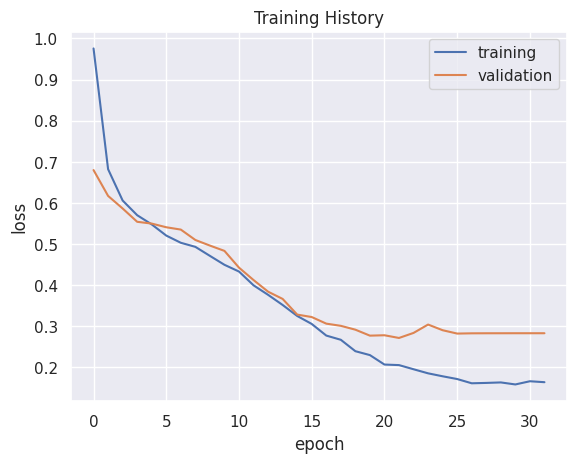

In [155]:
## PLOTTING HISTORY

# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()



150/150 [==============================] - 0s 2ms/step


Text(0.5, 0, 'FPR')

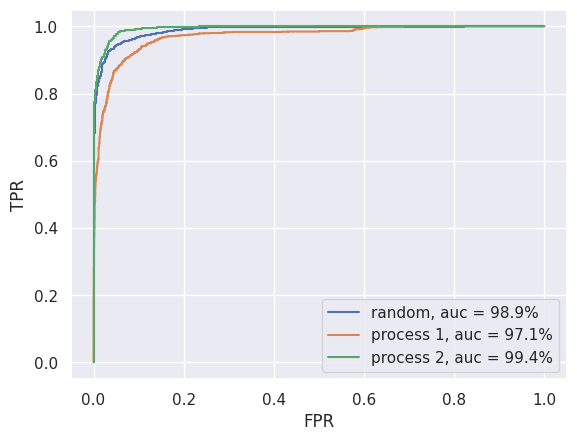

In [156]:
from sklearn.metrics import roc_curve, auc
import pandas as pd

labels = ['random', 'process 1', 'process 2']
predict_test = model.predict(X_test)

df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
    df[label] = y_test[:,i]
    df[label + '_pred'] = predict_test[:,i]

    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

    auc1[label] = auc(fpr[label], tpr[label])
    plt.plot(fpr[label], tpr[label],label='%s, AUC = %.1f%%'%(label,auc1[label]*100.))
plt.legend()
plt.ylabel('TPR')
plt.xlabel('FPR')


##2.2  CNN

In [158]:
n_qubits = 5 # quantum unit of computation
            # determining the dimension of the state matrix
            # matrix.shape = (2**(n_qubits),2**(n_qubits))
size = 2**n_qubits*1000
(X_train, X_val, X_test,
 y_train, y_val, y_test) = make_multiclass_dataset(n_qubits, size)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [159]:
print('train\t\t',X_train.shape)
print('validation\t',X_val.shape)
print('test\t\t',X_test.shape)

train		 (22398, 32, 32)
validation	 (4800, 32, 32)
test		 (4800, 32, 32)


When using the CNN we do not need flattened the density matrices and join real and imaginary part, in fact we can work directly with matrices in multiple channels (one for the real part, one for the imaginary).

In [160]:
# splitting real and imaginary part
X_train = np.array(list(map(lambda x: [x.real,x.imag], X_train)))#flatten()
print(X_train.shape)
X_val = np.array(list(map(lambda x: [x.real,x.imag], X_val)))
X_test = np.array(list(map(lambda x: [x.real,x.imag], X_test)))

(22398, 2, 32, 32)


### 2.2.1 Build and train model

To address this classification task one can employ a Multi-Layer Perceptron. Since we are performing multiclass classification it is important that the output layer has one neuron per class with `softmax` activation function.

In [161]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv1D, AveragePooling1D, MaxPooling1D, Dropout, Flatten, Activation
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Activation, Conv2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [162]:
input_shape = X_train.shape[1:]#(512,1)#((2**n_qubits)**2)*2
dropoutRate = 0.25

####
inputArray = Input(shape=(input_shape))
#
x = Conv2D(10, kernel_size=(3,3), data_format="channels_first", strides=1, padding="valid", activation='relu')(inputArray)
x = MaxPooling2D(pool_size=(2,2), data_format="channels_first")(x)
#
x = Conv2D(20, kernel_size=(3,3), data_format="channels_first", strides=1, padding="valid", activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2), data_format="channels_first")(x)
#
x = Flatten(data_format="channels_first",)(x)
#
x = Dense(40)(x)
x = Activation('relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(20)(x)
x = Activation('relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(10, activation='relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(5, activation='relu')(x)
#
output = Dense(3, activation='softmax')(x)
####
model = Model(inputs=inputArray, outputs=output)

For the same reason we employ the `categorical_crossentropy` as the the cost function for our training.

In [163]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 2, 32, 32)]       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 10, 30, 30)        190       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 10, 15, 15)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 20, 13, 13)        1820      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 20, 6, 6)         0         
 g2D)                                                            
                                                                 
 flatten_19 (Flatten)        (None, 720)               0  

In [164]:
batch_size = 28
n_epochs = 100

# train
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])


Epoch 1/100
800/800 - 8s - loss: 0.8148 - val_loss: 0.6139 - lr: 0.0010 - 8s/epoch - 10ms/step
Epoch 2/100
800/800 - 4s - loss: 0.5975 - val_loss: 0.5164 - lr: 0.0010 - 4s/epoch - 5ms/step
Epoch 3/100
800/800 - 4s - loss: 0.5190 - val_loss: 0.4417 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 4/100
800/800 - 4s - loss: 0.4623 - val_loss: 0.3724 - lr: 0.0010 - 4s/epoch - 5ms/step
Epoch 5/100
800/800 - 4s - loss: 0.4136 - val_loss: 0.3474 - lr: 0.0010 - 4s/epoch - 5ms/step
Epoch 6/100
800/800 - 4s - loss: 0.3736 - val_loss: 0.2949 - lr: 0.0010 - 4s/epoch - 5ms/step
Epoch 7/100
800/800 - 4s - loss: 0.3479 - val_loss: 0.3845 - lr: 0.0010 - 4s/epoch - 5ms/step
Epoch 8/100
800/800 - 4s - loss: 0.3180 - val_loss: 0.2947 - lr: 0.0010 - 4s/epoch - 5ms/step
Epoch 9/100
800/800 - 4s - loss: 0.2933 - val_loss: 0.2544 - lr: 0.0010 - 4s/epoch - 5ms/step
Epoch 10/100
800/800 - 5s - loss: 0.2794 - val_loss: 0.2479 - lr: 0.0010 - 5s/epoch - 6ms/step
Epoch 11/100
800/800 - 4s - loss: 0.2681 - val_loss: 0.232

### 2.2.2 Data analysis

In this section, we evaluate the performance of the trained model. As a first step one can give a look to the (train and validation) loss history during training. From this one can check if the training procedure was succesful and detect the possible presence of overfitting. Even in this case, after 15 epochs training and validation losses start to depart from each other like for the MLP, but here the phenomenon is less evident. Generalization on the test set was improved as can be appreciated by the ROC curve (AUC is inceased of 0.2% for all classes).

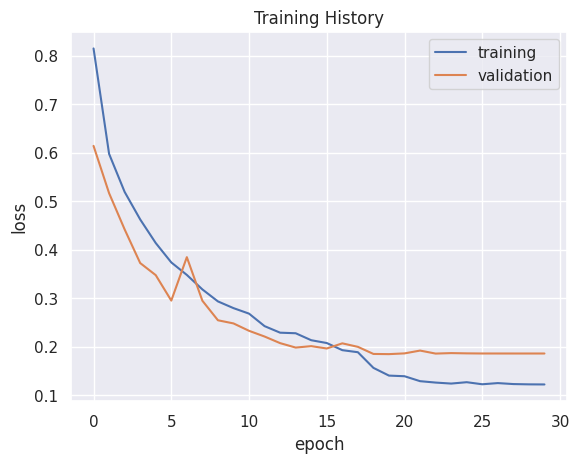

In [165]:
## PLOTTING HISTORY

# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()



150/150 [==============================] - 0s 2ms/step


Text(0.5, 0, 'FPR')

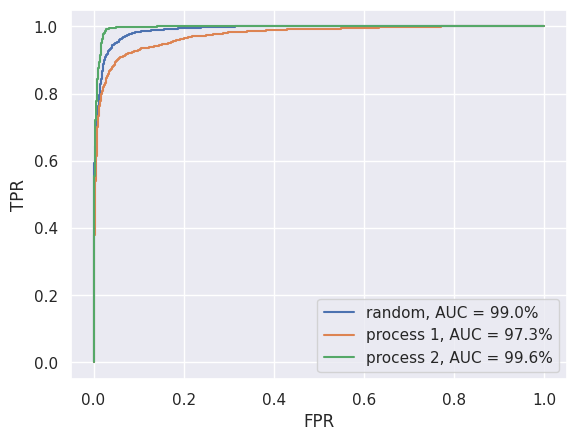

In [167]:
from sklearn.metrics import roc_curve, auc
import pandas as pd

labels = ['random', 'process 1', 'process 2']
predict_test = model.predict(X_test)

df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
    df[label] = y_test[:,i]
    df[label + '_pred'] = predict_test[:,i]

    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

    auc1[label] = auc(fpr[label], tpr[label])
    plt.plot(fpr[label], tpr[label],label='%s, AUC = %.1f%%'%(label,auc1[label]*100.))
plt.legend()
plt.ylabel('TPR')
plt.xlabel('FPR')
